In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pandas as pd
import pynwb
import graph
import glob
import os
from pathlib import Path 
import warnings

from sklearn.cluster import KMeans
from numpy import linalg as LA
import statsmodels.api as sm
from scipy.stats import nbinom
from scipy import stats
from scipy import optimize
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import average_precision_score
from sklearn.metrics import balanced_accuracy_score
from scipy.optimize import curve_fit
from scipy.optimize import differential_evolution
from scipy.stats import ttest_rel
from scipy.stats import norm
from scipy.stats import f
from scipy.stats import chi2
from scipy import signal
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.formula.api import ols
import matplotlib
from sklearn.metrics import confusion_matrix
import matplotlib.gridspec as gridspec
import joblib
import pickle
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
from scipy.signal import resample, find_peaks
from scipy.interpolate import interp1d
from numpy.lib.stride_tricks import sliding_window_view


%matplotlib widget

import load_data
import single_neuron_vis

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# 500ms window spike counts
ses_info = {'session':['031723','032823','033123','032023','040423','040723','050824',  # Bart
               '101124', '100324', '092124', '092324', '092524', '100124','100924'],
           'animal': ['Bart']*7+['London']*7}
all_sessions = pd.DataFrame(ses_info)  # London


region = 'OFC'
all_FR = []
OFC_units = pd.DataFrame()

for ii in range(1): #range(len(all_sessions)):

    session = all_sessions.iloc[ii].session
    animal = all_sessions.iloc[ii].animal
    print(animal, session)

    
    results = load_data.load_beh_neural(animal, session, region, 'action_on', 'trialerror<2')
    spikes, df, unitNames = results['spikes'], results['beh'], results['unitNames']
    df['value'] = np.maximum(0,3-df['graph_distance'].values)

    flash_idx = df.trialerror.values==1
    nav_idx = df.trialerror.values==0
    goal_not_start = ~(np.isin(df.node.values,[1,7,8,14]) & (df.step==0))
    

    FR = np.zeros((17,spikes.shape[2]))

    for gg, target in enumerate(np.sort(df.target.unique())):

        gg_idx = df.target.values==target           
        FR[-1,:] = spikes[flash_idx & gg_idx,500:,:].sum(axis=1).mean(axis=0)
    
        for vv in np.sort(df.value.unique()):
        
            vv_idx = df.value.values==vv
            FR[int(gg*4+vv),:] = spikes[nav_idx & vv_idx & gg_idx & goal_not_start,500:,:].sum(axis=1).mean(axis=0)

    all_FR.append(FR)
    OFC_units = pd.concat([OFC_units,unitNames])

# convert spike counts in 500ms to FR, /0.5
all_FR = np.hstack(all_FR)/0.5
OFC_units['meanFR'] = list(all_FR.T)

# save_path = f"/Volumes/Extreme SSD/Subspace/goal value {region} mean FR, goal not start.pkl"

# # Save both objects together in a dictionary
# with open(save_path, "wb") as f:
#     pickle.dump({
#         "df": OFC_units
#     }, f)

In [212]:
ses_info = {'session':['031723','032823','033123','032023','040423','040723','050824',  # Bart
           '101124', '100324', '092124', '092324', '092524', '100124','100924'],
       'animal': ['Bart']*7+['London']*7}
all_sessions = pd.DataFrame(ses_info)  # London


region = 'OFC'
win = 100
step = 10
start = win
n_ts = len(np.arange(start,1000-win+step,step))

all_FR = []
OFC_units = pd.DataFrame()

ii=0
session = all_sessions.iloc[ii].session
animal = all_sessions.iloc[ii].animal
print(animal, session)


results = load_data.load_beh_neural(animal, session, region, 'action_on', 'trialerror<2')
spikes, df, unitNames = results['spikes'], results['beh'], results['unitNames']
df['value'] = np.maximum(0,3-df['graph_distance'].values)


Bart 031723
Building Spike Table


1727it [00:01, 1259.59it/s]


In [40]:
# 2*100ms sliding window spike counts, 10ms step size

ses_info = {'session':['031723','032823','033123','032023','040423','040723','050824',  # Bart
               '101124', '100324', '092124', '092324', '092524', '100124','100924'],
           'animal': ['Bart']*7+['London']*7}
all_sessions = pd.DataFrame(ses_info)  # London


region = 'OFC'
win = 100
step = 10
start = win
n_ts = len(np.arange(start,1000-win+step,step))

all_FR = []
OFC_units = pd.DataFrame()

for ii in range(len(all_sessions)):

    session = all_sessions.iloc[ii].session
    animal = all_sessions.iloc[ii].animal
    print(animal, session)

    
    results = load_data.load_beh_neural(animal, session, region, 'action_on', 'trialerror<2')
    spikes, df, unitNames = results['spikes'], results['beh'], results['unitNames']
    df['value'] = np.maximum(0,3-df['graph_distance'].values)

    flash_idx = df.trialerror.values==1
    nav_idx = df.trialerror.values==0
    goal_not_start = ~(np.isin(df.node.values,[1,7,8,14]) & (df.step==0))
    
    
    FR = np.zeros((4,5,n_ts,spikes.shape[2]))
        
    for gg, target in enumerate(np.sort(df.target.unique())):
    
        gg_idx = df.target.values == target
        spk = spikes[flash_idx & gg_idx, :, :].mean(axis=0)
        spk_win = sliding_window_view(spk, win*2, axis=0).mean(axis=2)[start-win::step]*1000
        FR[gg,-1,:,:] = spk_win
    
        for vv in np.sort(df.value.unique()):
    
            vv_idx = df.value.values == vv
            spk = spikes[nav_idx & vv_idx & gg_idx & goal_not_start, :, :].mean(axis=0)
            spk_win = sliding_window_view(spk, win*2, axis=0).mean(axis=2)[start-win::step]*1000
            FR[gg, int(vv),:, :] = spk_win

    all_FR.append(FR.reshape(-1,spikes.shape[2]))
    OFC_units = pd.concat([OFC_units,unitNames])

all_FR = np.hstack(all_FR)
OFC_units['meanFR'] = list(all_FR.T)

save_path = f"/Volumes/Extreme SSD/Subspace/goal value {region} mean FR, goal not start, sliding.pkl"

# Save both objects together in a dictionary
with open(save_path, "wb") as f:
    pickle.dump({
        "df": OFC_units
    }, f)

Bart 031723
Building Spike Table


1727it [00:01, 1240.75it/s]


Bart 032823
Building Spike Table


2095it [00:01, 1117.59it/s]


Bart 033123
Building Spike Table


2319it [00:01, 1275.82it/s]


Bart 032023
Building Spike Table


2566it [00:01, 1409.63it/s]


Bart 040423
Building Spike Table


2746it [00:02, 915.69it/s] 


Bart 040723
Building Spike Table


2332it [00:02, 1135.26it/s]


Bart 050824
Building Spike Table


1529it [00:03, 470.36it/s]


London 101124
Building Spike Table


2735it [00:05, 503.47it/s]


London 100324
Building Spike Table


2597it [00:04, 618.91it/s]


London 092124
Building Spike Table


2581it [00:05, 497.49it/s]


London 092324
Building Spike Table


2630it [00:05, 507.63it/s]


London 092524
Building Spike Table


2606it [00:05, 487.91it/s]


London 100124
Building Spike Table


2614it [00:05, 500.89it/s]


London 100924
Building Spike Table


2616it [00:04, 604.91it/s]


In [3]:
region = 'OFC'
save_path = f"/Volumes/Extreme SSD/Subspace/goal value {region} mean FR, goal not start, sliding.pkl"

# Save both objects together in a dictionary
with open(save_path, "rb") as f:
    data = pickle.load(f)['df']

all_FR = np.stack(data.meanFR.values).T

In [390]:
def get_flash_dynamics(animal,session,region = 'OFC'):
        
    # get flash trial average dynamics
    # project flash trial dynamics into this subspace
    
    query = 'trialerror==1'
    neural_timeseries_index = 0
    unit_params = {"drift": 2, "min_fr": 1}
    
    nwbfile = load_data.load_nwbfile(animal, session)
    
    unitNames = nwbfile.units.to_dataframe()
    unit_idx = np.where((unitNames.region == region) & (unitNames.group == "good") & (unitNames.drift <= unit_params["drift"]) & (unitNames.fr >= unit_params["min_fr"]))[0]
    
    trial_df = nwbfile.intervals['trials'].to_dataframe().query(query)
    node_df = nwbfile.intervals['node_on'].to_dataframe().query(query)
    action_df = nwbfile.intervals['action_on'].to_dataframe().query(query)
    reward_df = nwbfile.intervals['reward_on'].to_dataframe().query(query)
    
    trial_df['node_on'] = node_df.t_on.values
    trial_df['action_on'] = action_df.t_on.values
    trial_df['reward_on'] = reward_df.t_on.values
    trial_df['trial_in_block'] = trial_df.groupby('block').cumcount()
    trial_df.reset_index(inplace=True,drop=True)
    
    
    node2action = np.zeros((len(trial_df),15,len(unit_idx)))
    action2reward = np.zeros((len(trial_df),40,len(unit_idx)))
    reward2end = np.zeros((len(trial_df),50,len(unit_idx)))
    
    for ii, row in trial_df.iterrows():
    
        
        trial_spikes = row.timeseries[neural_timeseries_index].data[:,unit_idx]
        x_pad = np.pad(trial_spikes, pad_width=((win, win),(0, 0)), mode="edge")
        trial_sdf = sliding_window_view(x_pad, win*2, axis=0).mean(axis=2)[:trial_spikes.shape[0]]*1000
        
        trial_time = np.arange(row.start_time,row.stop_time)
        if trial_spikes.shape[0]>len(trial_time):
            print(f'Mismatch: {trial_spikes.shape[0]-len(trial_time)}')
        
        
        time_idx =  (trial_time > row.node_on) & (trial_time < row.action_on)
        temp = trial_sdf[time_idx[:trial_spikes.shape[0]],:]
        x_old = np.linspace(0, 1, temp.shape[0])
        x_new = np.linspace(0, 1, 150)
        f = interp1d(x_old, temp, axis=0, kind='linear', bounds_error=False, fill_value=0)
        node2action[ii,:] = f(x_new)[::10,:]
        
        
        time_idx =  (trial_time > row.action_on) & (trial_time < (row.action_on+401))
        action2reward[ii,:] = trial_sdf[time_idx[:trial_spikes.shape[0]],:][:400:10,:]
        
        time_idx =  (trial_time > row.reward_on) & (trial_time < (row.reward_on+501))
        reward2end[ii,:] = trial_sdf[time_idx[:trial_spikes.shape[0]],:][:500:10,:]
        
        
    trial_df = trial_df.drop(columns=["timeseries"])
    trial_df['node2action'] = list(node2action)
    trial_df['action2reward'] = list(action2reward)
    trial_df['reward2end'] = list(reward2end)
        
        
    return trial_df

In [238]:
def get_nav_dynamics(animal,session,region = 'OFC'):
        
    # get flash trial average dynamics
    # project flash trial dynamics into this subspace
    
    query = '(trialerror==0)&(nsteps<5)'
    neural_timeseries_index = 0
    unit_params = {"drift": 2, "min_fr": 1}
    
    nwbfile = load_data.load_nwbfile(animal, session)
    
    unitNames = nwbfile.units.to_dataframe()
    unit_idx = np.where((unitNames.region == region) & (unitNames.group == "good") & (unitNames.drift <= unit_params["drift"]) & (unitNames.fr >= unit_params["min_fr"]))[0]
    
    trial_df = nwbfile.intervals['trials'].to_dataframe().query(query)
    node_df = nwbfile.intervals['node_on'].to_dataframe().query(query)
    action_df = nwbfile.intervals['action_on'].to_dataframe().query(query)
    reward_df = nwbfile.intervals['reward_on'].to_dataframe().query(query)
    
    trial_df['trial_in_block'] = trial_df.groupby('block').cumcount()
    trial_df.reset_index(inplace=True,drop=True)
    
    node2action = np.zeros((len(trial_df),25,len(unit_idx)))
    post_action = np.zeros((len(trial_df),5,40,len(unit_idx)))*np.nan
    reward2end = np.zeros((len(trial_df),50,len(unit_idx)))
    
    for ii, row in trial_df.iterrows():
        
        trial_spikes = row.timeseries[neural_timeseries_index].data[:,unit_idx]
        x_pad = np.pad(trial_spikes, pad_width=((win, win),(0, 0)), mode="edge")
        trial_sdf = sliding_window_view(x_pad, win*2, axis=0).mean(axis=2)[:trial_spikes.shape[0]]*1000
        
        trial_time = np.arange(row.start_time,row.stop_time)
        if trial_spikes.shape[0]>len(trial_time):
            print(f'Mismatch: {trial_spikes.shape[0]-len(trial_time)}')


~~~~~~could go wrong here, index the wrong trial?
        
        trial = row.trial
        nsteps = int(row.nsteps)
        node_on = node_df[(node_df.trial==trial)&(node_df.step==0)].t_on.values
        action_on = action_df[action_df.trial==trial].t_on.values
        reward_on = reward_df[reward_df.trial==trial].t_on.values
    
        
        time_idx =  (trial_time > node_on) & (trial_time < action_on[0])
        temp = trial_sdf[time_idx[:trial_spikes.shape[0]],:]
        x_old = np.linspace(0, 1, temp.shape[0])
        x_new = np.linspace(0, 1, 250)
        f = interp1d(x_old, temp, axis=0, kind='linear', bounds_error=False, fill_value=0)
        node2action[ii,:] = f(x_new)[::10,:]
    
        time_idx =  (trial_time > reward_on) & (trial_time < (reward_on+501))
        reward2end[ii,:] = trial_sdf[time_idx[:trial_spikes.shape[0]],:][:500:10,:]
    
        for step in range(nsteps+1):
            time_idx =  (trial_time > action_on[step]) & (trial_time < (action_on[step]+401))
            post_action[ii,step,:] = trial_sdf[time_idx[:trial_spikes.shape[0]],:][:400:10,:]
    
    trial_df = trial_df.drop(columns=["timeseries"])
    trial_df['node2action'] = list(node2action)
    trial_df['post_action'] = list(post_action)
    trial_df['reward2end'] = list(node2action)
    
    
    return trial_df

In [410]:
flash_sdf = pd.DataFrame()
# nav_sdf = pd.DataFrame()

for ii in range(len(all_sessions)):

    session = all_sessions.iloc[ii].session
    animal = all_sessions.iloc[ii].animal
    print(animal, session)

    flash_temp = get_flash_dynamics(animal,session)
    # nav_temp = get_nav_dynamics(animal,session)

    flash_temp['animal']=animal
    flash_temp['session']=session

    # nav_temp['animal']=animal
    # nav_temp['session']=session
    
    flash_sdf = pd.concat([flash_sdf,flash_temp])
    # nav_sdf = pd.concat([nav_sdf,nav_temp])


# save_path = f"/Volumes/Extreme SSD/Subspace/flash average sdf {region}.pkl"

# # Save both objects together in a dictionary
# with open(save_path, "wb") as f:
#     pickle.dump({
#         "df": flash_sdf
#     }, f)
    

# save_path = f"/Volumes/Extreme SSD/Subspace/nav average sdf {region}.pkl"

# # Save both objects together in a dictionary
# with open(save_path, "wb") as f:
#     pickle.dump({
#         "df": nav_sdf
#     }, f)

Bart 031723
Bart 032823
Bart 033123


/opt/anaconda3/lib/python3.12/site-packages/scipy/interpolate/_interpolate.py:712: RuntimeWarning:

invalid value encountered in divide



Bart 032023


/opt/anaconda3/lib/python3.12/site-packages/scipy/interpolate/_interpolate.py:712: RuntimeWarning:

invalid value encountered in divide



Bart 040423


/opt/anaconda3/lib/python3.12/site-packages/scipy/interpolate/_interpolate.py:712: RuntimeWarning:

invalid value encountered in divide



Bart 040723


/opt/anaconda3/lib/python3.12/site-packages/scipy/interpolate/_interpolate.py:712: RuntimeWarning:

invalid value encountered in divide



Bart 050824
London 101124
London 100324
London 092124
London 092324
London 092524
London 100124
London 100924


In [5]:
# load in sdf data
save_path = f"/Volumes/Extreme SSD/Subspace/nav trial FR {region}.pkl"

# Save both objects together in a dictionary
with open(save_path, "rb") as f:
    nav_sdf = pickle.load(f)['df']


save_path = f"/Volumes/Extreme SSD/Subspace/flash trial FR {region}.pkl"

# Save both objects together in a dictionary
with open(save_path, "rb") as f:
    flash_sdf = pickle.load(f)['df']

In [ ]:
# look at flash trial dynamics separately for each target
# same for navigation trials

In [7]:
sz1 = 12
sz2 = 12
sns.set(style="ticks", rc={"lines.linewidth": 1})
matplotlib.rc('xtick', labelsize=sz1) 
matplotlib.rc('ytick', labelsize=sz1) 
matplotlib.rc('axes', labelsize=sz1)  
matplotlib.rc('axes', titlesize=sz1)  
matplotlib.rc('figure', titlesize=sz2)
matplotlib.rc('legend', fontsize=sz1) 
matplotlib.rc('legend', title_fontsize=sz1)
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False

colors16 = [
    "#1f77b4","#ff7f0e","#2ca02c","#d62728",
    "#9467bd","#8c564b","#e377c2","#7f7f7f",
    "#bcbd22","#17becf","#a55194","#393b79",
    "#637939","#8c6d31","#843c39","#cedb9c"
]

In [ ]:
flash_target_sdf = flash_sdf.groupby(['animal','session', 'target'], sort=False).\
                    apply(lambda g: np.nanmean(np.stack(g.action2reward.values),axis=0)).reset_index(name='meansdf')
target_specific_sdf = np.zeros((4,40,1522))
for ii, target in enumerate([1,7,8,14]):
    target_specific_sdf[ii,:] = np.hstack(flash_target_sdf.query('(target==@target)').meansdf.values)

nav_target_sdf = (
    nav_sdf[~np.isin(nav_sdf.start.values,[1,7,8,14])]
    .groupby(['animal', 'session', 'nsteps'], sort=False)
    .apply(lambda g: pd.Series({ 
        'post0_mean': np.nanmean(np.stack(g.post_action.values)[:,0,:,:],axis=0),
        'post1_mean': np.nanmean(np.stack(g.post_action.values)[:,1,:,:],axis=0),
        'post2_mean': np.nanmean(np.stack(g.post_action.values)[:,2,:,:],axis=0),
        'post3_mean': np.nanmean(np.stack(g.post_action.values)[:,3,:,:],axis=0),
        'post4_mean': np.nanmean(np.stack(g.post_action.values)[:,4,:,:],axis=0),
    }))
    .reset_index()
)

In [103]:
# 500ms spike counts

region = 'OFC'
save_path = f"/Volumes/Extreme SSD/Subspace/goal value {region} mean FR, goal not start.pkl"

# Save both objects together in a dictionary
with open(save_path, "rb") as f:
    data = pickle.load(f)['df']

all_FR = np.stack(data.meanFR.values).T

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=3))
])

pipe.fit(all_FR[:-1,:])
red_X = pipe.transform(all_FR[:-1,:]).reshape((4,4,3))
nav_X = red_X.copy()

In [105]:
# -----------------------------
# Settings
# -----------------------------
targets = [1, 7, 8, 14]
values = np.arange(4)

colors = {
    1: "#636EFA",
    7: "#EF553B",
    8: "#00CC96",
    14: "#AB63FA"
}


# [
#     "#636EFA",  # blue
#     "#EF553B",  # red-orange
#     "#00CC96",  # green
#     "#AB63FA",  # purple
#     "#FFA15A",  # orange
#     "#19D3F3",  # cyan
#     "#FF6692",  # pink
#     "#B6E880",  # light green
#     "#FF97FF",  # light pink
#     "#FECB52",  # yellow
# ]


# -----------------------------
# Figure
# -----------------------------
fig = go.Figure()

# -----------------------------
# Real data traces (no legend)
# -----------------------------
for ii, target in enumerate(targets):

    color = colors[target]

    fig.add_trace(
        go.Scatter3d(
            x=nav_X[ii, :, 0],
            y=nav_X[ii, :, 1],
            z=nav_X[ii, :, 2],
            mode="lines+markers",
            marker=dict(
                size = 5 + np.arange(4)*4,
                symbol="circle",
                color=color
            ),
            
            line=dict(width= 2, color=color),
            legendgroup=f"target_{target}",
            showlegend=False
        )
    )


# -----------------------------
# Layout
# -----------------------------
fig.update_layout(
    scene=dict(
        xaxis_title="PC1",
        yaxis_title="PC2",
        zaxis_title="PC3"
    ),
    title=f"{region}, action on 0–400 ms",
    width=800,
    height=800,
    legend=dict(tracegroupgap=10)
)

fig.show()
fig.write_html(save_path[:-4]+' 3d plot.html')



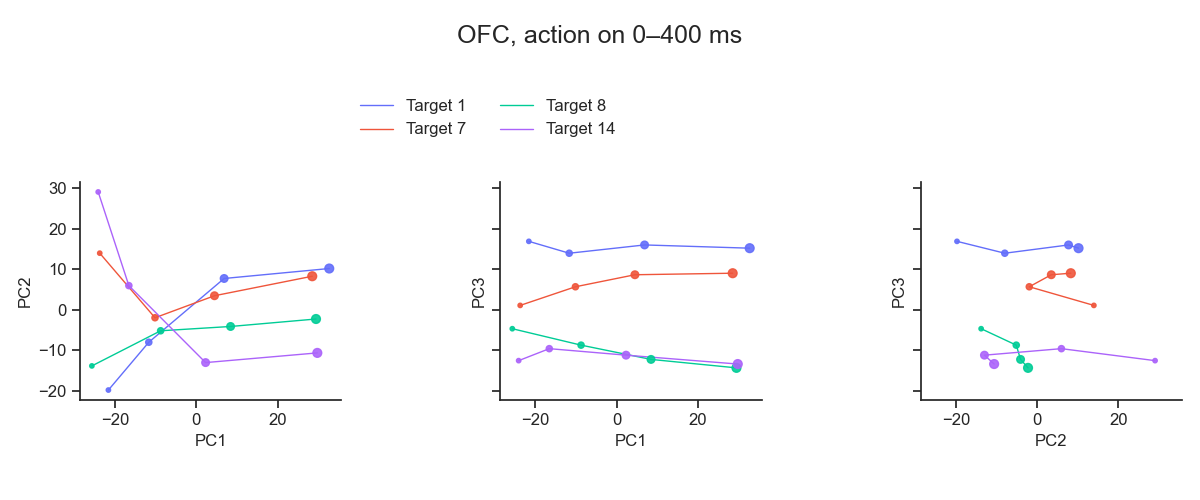

In [107]:
# 2d projections

targets = [1, 7, 8, 14]
values = np.arange(4)

colors = {
    1: "#636EFA",
    7: "#EF553B",
    8: "#00CC96",
    14: "#AB63FA"
}

proj_pairs = [
    (0, 1, "PC1", "PC2"),
    (0, 2, "PC1", "PC3"),
    (1, 2, "PC2", "PC3"),
]

# -----------------------------
# Figure
# -----------------------------
plt.close("all")
fig, axes = plt.subplots(1, 3, figsize=(12, 5), sharex=True, sharey=True)

# -----------------------------
# Plot
# -----------------------------
for ax, (i, j, xlabel, ylabel) in zip(axes, proj_pairs):

    for ii, target in enumerate(targets):
        color = colors[target]

        ax.plot(
            nav_X[ii, :, i],
            nav_X[ii, :, j],
            color=color,
            linewidth=1,
            zorder=2
        )

        ax.scatter(
            nav_X[ii, :, i],
            nav_X[ii, :, j],
            s= 10 + np.arange(nav_X.shape[1]) * 10,
            color=color,
            alpha=0.9,
            zorder=3
        )

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_aspect("equal")

# -----------------------------
# Legend
# -----------------------------
legend_handles = [
    plt.Line2D([0], [0], color=colors[t], lw=1, label=f"Target {t}")
    for t in targets
]

axes[1].legend(
    handles=legend_handles,
    bbox_to_anchor=(0.5, 1.45),
    ncol=2,
    frameon=False
)

# -----------------------------
# Title & layout
# -----------------------------
plt.suptitle(f"{region}, action on 0–400 ms", fontsize=18, y=0.95)
plt.tight_layout(rect=[0,0,1,0.95])
plt.savefig(save_path[:-4]+' 2d projection')


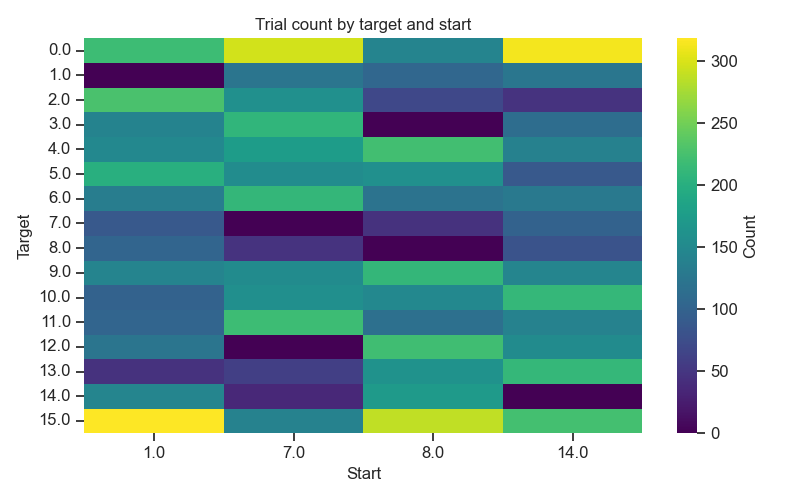

In [123]:
# group & count
heat_df = (
    nav_sdf
    .groupby(['target', 'start'])
    .size()                 # count rows per (target, start)
    .unstack(fill_value=0)  # rows=target, cols=start
)

# plot heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(
    heat_df.T,
    cmap="viridis",
    cbar_kws=dict(label="Count")
)

plt.xlabel("Start")
plt.ylabel("Target")
plt.title("Trial count by target and start")
plt.tight_layout()
plt.show()


In [13]:
# 200ms sliding window, combine all targets

win = 100
step = 10
start = win
n_ts = len(np.arange(start,1000-win+step,step))

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=3))
])

mid_idx = int(n_ts/2)
action_chunk = all_FR.reshape(4,5,n_ts,-1)[:,:,int(n_ts/2):,:].reshape(4*5*(int(n_ts/2)+1),-1)

pipe.fit(action_chunk)
red_X = pipe.transform(action_chunk).reshape(4,5,int(n_ts/2)+1,3)
nav_X = red_X[:,:-1,:,:].reshape((4,4,int(n_ts/2)+1,3))
flash_X = red_X[:,-1,:,:].reshape((4,int(n_ts/2)+1,3))

In [ ]:
# not simply spatial coding, but goal coding -> when goal is visited not at the first step nor reward

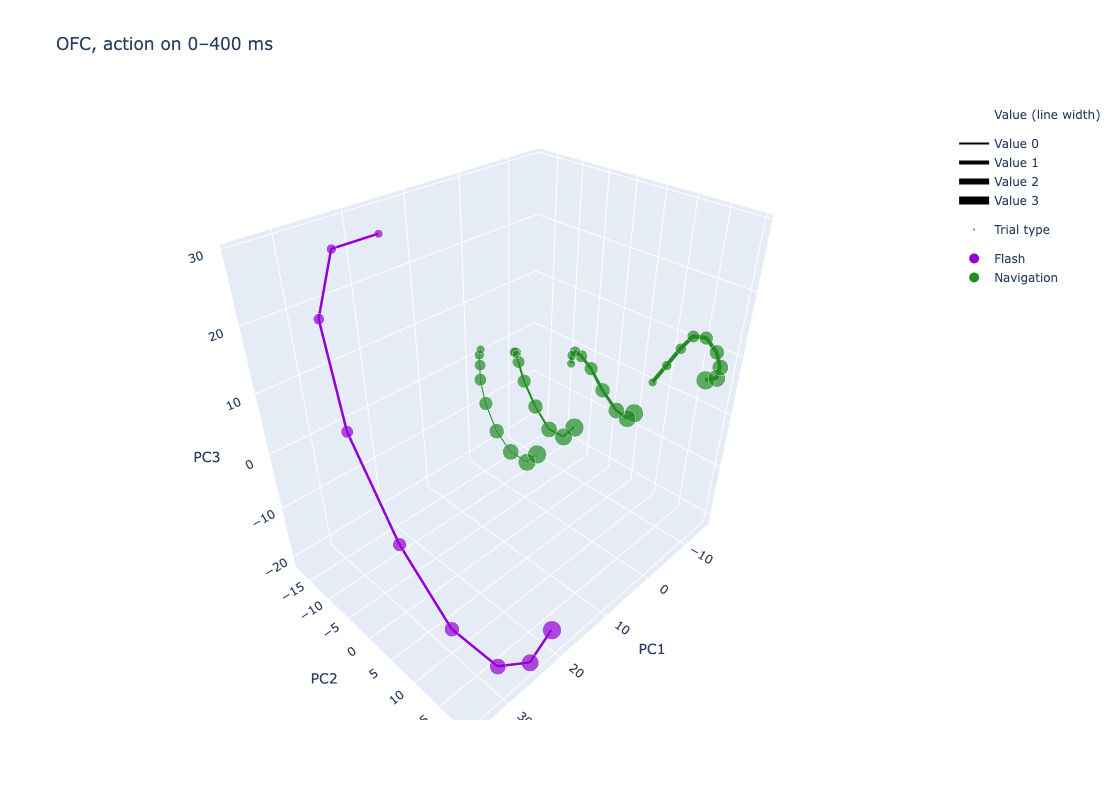

In [15]:
# 200ms sliding window, combine all targets

values = np.arange(4)
value_sizes = values * 9

trial_colors = {
    "Flash": "darkviolet",
    "Navigation": "forestgreen",
}

# -----------------------------
# Figure
# -----------------------------
fig = go.Figure()

# -----------------------------
# Real data traces (no legend)
# -----------------------------


# Flash trials
fig.add_trace(
    go.Scatter3d(
        x=flash_X[:, :, 0].mean(axis=0)[::5],
        y=flash_X[:, :, 1].mean(axis=0)[::5],
        z=flash_X[:, :, 2].mean(axis=0)[::5],
        mode="lines+markers",
        marker=dict(size=10 + 1.5 * np.arange(17), color='darkviolet'),
        line=dict(width=5, color='darkviolet'),
        showlegend=False
    )
)

# Navigation trials
for vv in range(4):
    fig.add_trace(
        go.Scatter3d(
            x=nav_X[:, vv, :, 0].mean(axis=0)[::5],
            y=nav_X[:, vv, :, 1].mean(axis=0)[::5],
            z=nav_X[:, vv, :, 2].mean(axis=0)[::5],
            mode="lines+markers",
            marker=dict(
                size= 10 + 1.5 * np.arange(17),
                color='forestgreen'
            ),
            line=dict(width= 2*vv+2, color='forestgreen'),
            showlegend=False
        )
    )

# -----------------------------
# Dummy legend: Value (line width)
# -----------------------------
fig.add_trace(go.Scatter3d(
    x=[None], y=[None], z=[None],
    mode="lines",
    line=dict(width=0),
    name="Value (line width)",
    showlegend=True
))

for vv in range(4):
    fig.add_trace(
        go.Scatter3d(
            x=[None], y=[None], z=[None],
            mode="lines",
            line=dict(
                width=2 * vv + 2,
                color="black"
            ),
            name=f"Value {vv}",
            legendgroup="value_width",
            showlegend=True
        )
    )


# -----------------------------
# Dummy legend: Trial type (symbol)
# -----------------------------
fig.add_trace(go.Scatter3d(
    x=[None], y=[None], z=[None],
    mode="markers",
    marker=dict(size=0),
    name="Trial type",
    showlegend=True
))

for label, color in trial_colors.items():
    fig.add_trace(
        go.Scatter3d(
            x=[None], y=[None], z=[None],
            mode="markers",
            marker=dict(size=10, color=color),
            name=label,
            legendgroup="trial_type",
            showlegend=True
        )
    )


# -----------------------------
# Layout
# -----------------------------
fig.update_layout(
    scene=dict(
        xaxis_title="PC1",
        yaxis_title="PC2",
        zaxis_title="PC3"
    ),
    title=f"{region}, action on 0–400 ms",
    width=800,
    height=800,
    legend=dict(tracegroupgap=10)
)

# fig.write_html("/Volumes/Extreme SSD/Subspace/OFC, flash and navigation.html")
fig.show()


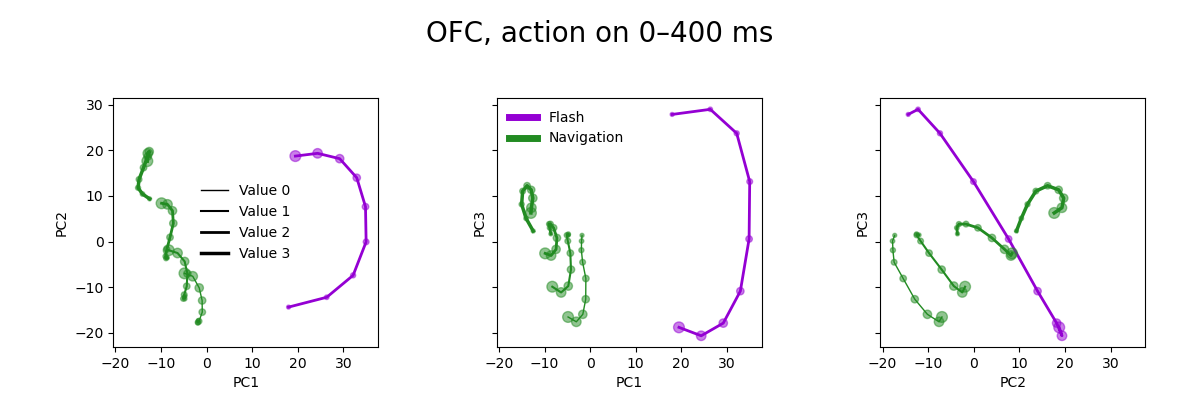

In [114]:
# 2d projection

values = np.arange(4)

trial_colors = {
    "Flash": "darkviolet",
    "Navigation": "forestgreen",
}

lw_values = {vv: 0.5 * vv + 1 for vv in values}

# -----------------------------
# Prepare data (average over targets)
# -----------------------------
flash_mean = flash_X.mean(axis=0)[mid_idx::5]          # (time, 3)
nav_mean = nav_X.mean(axis=0)[:,mid_idx::5,:]              # (value, time, 3)

# -----------------------------
# Figure
# -----------------------------
plt.close('all')
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)

proj_pairs = [
    (0, 1, "PC1", "PC2"),
    (0, 2, "PC1", "PC3"),
    (1, 2, "PC2", "PC3"),
]

# -----------------------------
# Plot
# -----------------------------
for ax, (i, j, xlabel, ylabel) in zip(axes, proj_pairs):

    # Flash
    ax.plot(
        flash_mean[:, i],
        flash_mean[:, j],
        color=trial_colors["Flash"],
        linewidth=2,
    )
    # Vary marker size along trajectory
    marker_sizes = np.logspace(np.log2(8), np.log2(60), num=flash_mean.shape[0], base=2) 
    ax.scatter(
        flash_mean[:, i],
        flash_mean[:, j],
        s=marker_sizes,  # marker size varies
        color=trial_colors["Flash"],
        label="Flash",
        zorder=3,
        alpha=0.5
    )

    # Navigation (value encoded by linewidth)
    for vv in values:
        ax.plot(
            nav_mean[vv, :, i],
            nav_mean[vv, :, j],
            color=trial_colors["Navigation"],
            linewidth=lw_values[vv],
        )
        marker_sizes = np.logspace(np.log2(8), np.log2(60), num=nav_mean.shape[1], base=2) 
        ax.scatter(
            nav_mean[vv, :, i],
            nav_mean[vv, :, j],
            s=marker_sizes,
            color=trial_colors["Navigation"],
            zorder=3,
            alpha=0.5
        )

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_aspect("equal")

# -----------------------------
# Legends
# -----------------------------
trial_handles = [
    plt.Line2D([0], [0], color=trial_colors["Flash"], lw=5, label="Flash"),
    plt.Line2D([0], [0], color=trial_colors["Navigation"], lw=5, label="Navigation"),
]

value_handles = [
    plt.Line2D([0], [0], color="black", lw=lw_values[vv], label=f"Value {vv}")
    for vv in values
]

axes[1].legend(
    handles=trial_handles,
    loc="best",
    frameon=False
)

axes[0].legend(
    handles=value_handles,
    loc="best",
    frameon=False
)

# -----------------------------
# Title & layout
# -----------------------------
plt.suptitle(f"{region}, action on 0–400 ms", y=0.95, fontsize=20)
plt.tight_layout(rect=[0,0.05,1,0.9])
plt.savefig("/Volumes/Extreme SSD/Subspace/OFC, flash and navigation, projection")


In [109]:
nav_target_sdf = (
    nav_sdf[~np.isin(nav_sdf.start.values,[1,7,8,14])]
    .groupby(['animal', 'session', 'nsteps'], sort=False)
    .apply(lambda g: pd.Series({ 
        'post0_mean': np.nanmean(np.stack(g.post_action.values)[:,0,:,:],axis=0),
        'post1_mean': np.nanmean(np.stack(g.post_action.values)[:,1,:,:],axis=0),
        'post2_mean': np.nanmean(np.stack(g.post_action.values)[:,2,:,:],axis=0),
        'post3_mean': np.nanmean(np.stack(g.post_action.values)[:,3,:,:],axis=0),
        'post4_mean': np.nanmean(np.stack(g.post_action.values)[:,4,:,:],axis=0),
    }))
    .reset_index()
)

/var/folders/vp/0ygvp9fj4dj79f756hg2wnwc0000gn/T/ipykernel_21493/1900526565.py:9: RuntimeWarning:

Mean of empty slice

/var/folders/vp/0ygvp9fj4dj79f756hg2wnwc0000gn/T/ipykernel_21493/1900526565.py:8: RuntimeWarning:

Mean of empty slice

/var/folders/vp/0ygvp9fj4dj79f756hg2wnwc0000gn/T/ipykernel_21493/1900526565.py:7: RuntimeWarning:

Mean of empty slice

/var/folders/vp/0ygvp9fj4dj79f756hg2wnwc0000gn/T/ipykernel_21493/1900526565.py:4: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [111]:
all_step_FR = []
for nsteps in range(1,5):  
    nav_step_FR = np.stack([np.hstack(nav_target_sdf.query('nsteps==@nsteps')[f'post{i}_mean'].values) for i in range(nsteps+1)])
    all_step_FR.append(nav_step_FR)

all_step_FR.append(target_specific_sdf[:,:30,:].mean(axis=0,keepdims=True))
all_step_FR = np.vstack(all_step_FR)

In [113]:
# 200ms sliding window, combine all targets
ncells = all_step_FR.shape[2]

pipe2 = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=3))
])

ncells = all_step_FR.shape[2]
temp = all_step_FR.reshape(-1,ncells)

pipe2.fit(temp)
step_X = pipe2.transform(temp).reshape(all_step_FR.shape[0],all_step_FR.shape[1],3)
step_X_flash = step_X[-1,:,:]
step_X_nav = [step_X[:2,:,:],step_X[2:5,:,:],step_X[5:9,:,:],step_X[9:14,:,:]]

In [165]:
from matplotlib.colors import to_rgb

def interp_palette(n, start, end):
    c1 = np.array(to_rgb(start))
    c2 = np.array(to_rgb(end))
    return [
        f'rgb({int(r*255)},{int(g*255)},{int(b*255)})'
        for r, g, b in np.linspace(c1, c2, n)
    ]



In [191]:
def float_to_plotly_color(c):
    """Convert (r,g,b) floats 0-1 to Plotly rgb string"""
    return f'rgb({int(c[0]*255)},{int(c[1]*255)},{int(c[2]*255)})'


In [217]:
# 200ms sliding window, combine all targets, look at trials with different lengths


values = np.arange(4)
value_sizes = values * 9
step_colors = sns.color_palette(palette='coolwarm',n_colors=5)


trial_colors = {
    "Flash": "darkviolet",
    "Nav value 4 ": float_to_plotly_color(step_colors[0]),
    "Nav value 3": float_to_plotly_color(step_colors[1]),
    "Nav value 2": float_to_plotly_color(step_colors[2]),
    "Nav value 1": float_to_plotly_color(step_colors[3]),
    "Nav value 0": float_to_plotly_color(step_colors[4])
}


# -----------------------------
# Figure
# -----------------------------
fig = go.Figure()

# -----------------------------
# Real data traces (no legend)
# -----------------------------


# Flash trials
fig.add_trace(
    go.Scatter3d(
        x=step_X_flash[:, 0][::5],
        y=step_X_flash[:, 1][::5],
        z=step_X_flash[:, 2][::5],
        mode="lines+markers",
        marker=dict(size=10 + 1.5 * np.arange(17), color='darkviolet'),
        line=dict(width=5, color='darkviolet'),
        showlegend=False
    )
)

# get nav FR with different lengths
for nsteps in range(1,5):
    
    nav_step_pc = step_X_nav[nsteps-1]
    
    
    # Navigation trials
    for ss in range(nsteps+1):
        fig.add_trace(
            go.Scatter3d(
                x=nav_step_pc[ss, :, 0][::5],
                y=nav_step_pc[ss, :, 1][::5],
                z=nav_step_pc[ss, :, 2][::5],
                mode="lines+markers",
                marker=dict(
                    size= 10 + 1.5 * np.arange(6),
                    color = float_to_plotly_color(step_colors[nsteps-ss])
                ),
                line=dict(width= 2+nsteps*2, color= float_to_plotly_color(step_colors[nsteps-ss])),
                showlegend=False
            )
        )

# -----------------------------
# Dummy legend: Value (line width)
# -----------------------------
fig.add_trace(go.Scatter3d(
    x=[None], y=[None], z=[None],
    mode="lines",
    line=dict(width=0),
    name="Trial length",
    showlegend=True
))

for vv in range(4):
    fig.add_trace(
        go.Scatter3d(
            x=[None], y=[None], z=[None],
            mode="lines",
            line=dict(
                width=2 * vv + 2,
                color="black"
            ),
            name=f"nsteps={vv+1}",
            legendgroup="step",
            showlegend=True
        )
    )


# -----------------------------
# Dummy legend: Trial type (symbol)
# -----------------------------
fig.add_trace(go.Scatter3d(
    x=[None], y=[None], z=[None],
    mode="markers",
    marker=dict(size=0),
    name="Trial type",
    showlegend=True
))

for label, color in trial_colors.items():
    fig.add_trace(
        go.Scatter3d(
            x=[None], y=[None], z=[None],
            mode="markers",
            marker=dict(size=10, color=color),
            name=label,
            legendgroup="trial_type",
            showlegend=True
        )
    )


# -----------------------------
# Layout
# -----------------------------
fig.update_layout(
    scene=dict(
        xaxis_title="PC1",
        yaxis_title="PC2",
        zaxis_title="PC3"
    ),
    title=f"{region}, action on 0–400 ms",
    width=800,
    height=800,
    legend=dict(tracegroupgap=10)
)

fig.update_layout(
    scene=dict(
        xaxis=dict(showbackground=False, gridcolor="lightgrey"),
        yaxis=dict(showbackground=False, gridcolor="lightgrey"),
        zaxis=dict(showbackground=False, gridcolor="lightgrey"),
        bgcolor="white"
    ),
    plot_bgcolor="black"
)
fig.update_layout(scene_camera=dict(projection=dict(type="orthographic")))

fig.write_html("/Volumes/Extreme SSD/Subspace/OFC, flash and navigation nsteps.html")
fig.show()


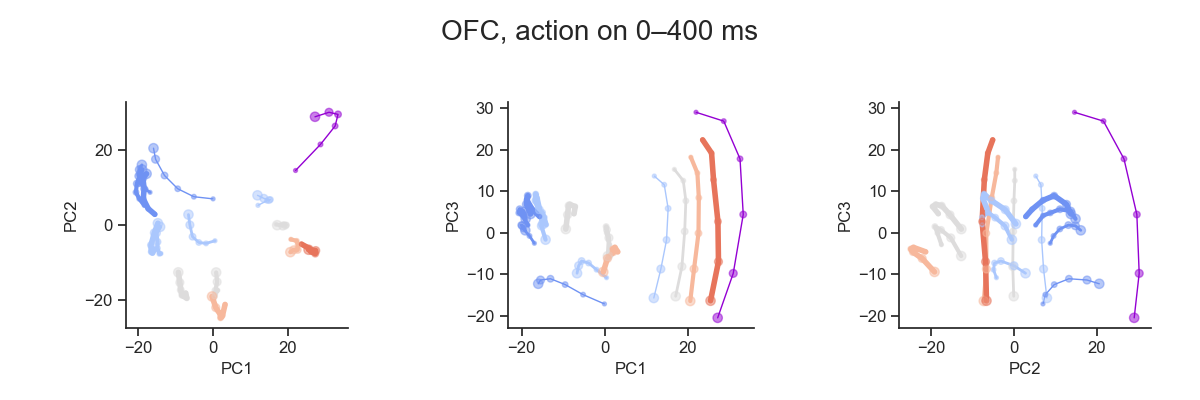

In [258]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# Parameters
# -----------------------------
proj_pairs = [
    (0, 1, "PC1", "PC2"),
    (0, 2, "PC1", "PC3"),
    (1, 2, "PC2", "PC3"),
]

values = np.arange(5)  # 0–4 for Nav values
value_sizes = values * 9  # (not used here, kept for consistency)
lw_values = {vv: 2 + vv*2 for vv in range(5)}  # line width encodes trial length / nsteps

# Color palette
step_colors = sns.color_palette('coolwarm', n_colors=5)

def float_to_rgb(c):
    return (c[0], c[1], c[2])

trial_colors = {
    "Flash": "darkviolet",
    "Nav value 4": float_to_rgb(step_colors[0]),
    "Nav value 3": float_to_rgb(step_colors[1]),
    "Nav value 2": float_to_rgb(step_colors[2]),
    "Nav value 1": float_to_rgb(step_colors[3]),
    "Nav value 0": float_to_rgb(step_colors[4])
}

# -----------------------------
# Figure
# -----------------------------
plt.close('all')
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharex=False, sharey=False)

# -----------------------------
# Plot Flash trials
# -----------------------------
for ax, (i, j, xlabel, ylabel) in zip(axes, proj_pairs):
    marker_sizes = np.logspace(np.log2(8), np.log2(60), num=step_X_flash.shape[0], base=2)
    
    ax.plot(step_X_flash[:, i][::5], step_X_flash[:, j][::5],
            color=trial_colors["Flash"], linewidth=1)
    
    ax.scatter(step_X_flash[:, i][::5], step_X_flash[:, j][::5],
               s=marker_sizes[::5],
               color=trial_colors["Flash"],
               alpha=0.5,
               zorder=3)

# -----------------------------
# Plot Navigation trials (values) — fix: color encodes value, line width encodes trial length
# -----------------------------
for ax, (i, j, xlabel, ylabel) in zip(axes, proj_pairs):
    for nsteps in range(1,5):  # vv = 0 → 4, color encodes this value
        
        nav_value_pc = step_X_nav[nsteps-1]  # (ntrials, time, 3)
        
        for ss in range(nsteps+1):  # ss = trial index → line width
            marker_sizes = np.logspace(np.log2(8), np.log2(60), num=nav_value_pc.shape[1], base=2)
            
            # Corrected: color = Nav value, linewidth = trial length (ss)
            ax.plot(nav_value_pc[ss, :, i][::5],
                    nav_value_pc[ss, :, j][::5],
                    color=step_colors[nsteps-ss],
                    linewidth=nsteps)
            
            ax.scatter(nav_value_pc[ss, :, i][::5],
                       nav_value_pc[ss, :, j][::5],
                       s=marker_sizes[::5],
                       color=step_colors[nsteps-ss],
                       alpha=0.5,
                       zorder=3)

# -----------------------------
# Labels & aspect
# -----------------------------
for ax, (_, _, xlabel, ylabel) in zip(axes, proj_pairs):
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_aspect('equal')

# -----------------------------
# Legends
# -----------------------------
# Trial type
trial_handles = [
    plt.Line2D([0], [0], color=trial_colors["Flash"], lw=5, label="Flash"),
    plt.Line2D([0], [0], color=trial_colors["Nav value 0"], lw=5, label="Navigation"),
]
# axes[1].legend(handles=trial_handles, bbox_to_anchor=(0.8, 1.1), frameon=False)

# Value / line width (trial length)
# value_handles = [
#     plt.Line2D([0], [0], color="black", lw=2 + vv*2, label=f"nsteps={vv+1}")
#     for vv in range(5)
# ]
# axes[0].legend(handles=value_handles, bbox_to_anchor=(0.2, 1.1), frameon=False, ncols=3)

# -----------------------------
# Title & layout
# -----------------------------
plt.suptitle(f"{region}, action on 0–400 ms", fontsize=20, y=0.95)
plt.tight_layout(rect=[0, 0.05, 1, 0.9])

# -----------------------------
# Save figure
# -----------------------------
plt.savefig("/Volumes/Extreme SSD/Subspace/OFC_flash_navigation_nsteps_2D_projection.png", dpi=300)
plt.show()


In [125]:
region = 'OFC'
save_path = f"/Volumes/Extreme SSD/Subspace/goal value {region} mean FR, goal not start, sliding.pkl"

# Save both objects together in a dictionary
with open(save_path, "rb") as f:
    data = pickle.load(f)['df']

all_FR = np.stack(data.meanFR.values).T

In [127]:
# 200ms sliding window, look at target coding

win = 100
step = 10
start = win
n_ts = len(np.arange(start,1000-win+step,step))

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=3))
])

mid_idx = int(n_ts/2)
action_chunk = all_FR.reshape(4,5,n_ts,-1)[:,:,int(n_ts/2):,:].reshape(4*5*(int(n_ts/2)+1),-1)

In [129]:
# the temporal dynamics is put into pc
# for fitting, only use navigation trials
nav_FR = all_FR.reshape(4,5,n_ts,-1)[:,:-1,int(n_ts/2):,:].reshape(4*4*(int(n_ts/2)+1),-1)
pipe.fit(nav_FR)

red_X = pipe.transform(action_chunk).reshape(4,5,int(n_ts/2)+1,3)
nav_X = red_X[:,:-1,:,:].reshape((4,4,int(n_ts/2)+1,3))
flash_X = red_X[:,-1,:,:].reshape((4,int(n_ts/2)+1,3))

In [131]:
# take out temporal dynamics
# only use navigation trials for fitting
temp = all_FR.reshape(4,5,n_ts,-1)[:,:,int(n_ts/2):,:]
temporal = np.tile(temp.mean(axis=0,keepdims=True),(4,1,1,1))
conditioned = (temp - temporal).reshape((4*5*(mid_idx+1),-1))
nav_conditioned = (temp - temporal)[:,:-1,:,:].reshape((4*4*(mid_idx+1),-1))

pipe.fit(nav_conditioned)

red_X = pipe.transform(conditioned).reshape(4,5,int(n_ts/2)+1,3)
nav_X = red_X[:,:-1,:,:].reshape((4,4,int(n_ts/2)+1,3))
flash_X = red_X[:,-1,:,:].reshape((4,int(n_ts/2)+1,3))

In [ ]:
target_FR = temp[:,-2:,:,:].reshape(-1,temp.shape[-1])
pipe.fit(target_FR)
target_X = pipe.transform(target_FR).reshape(4,2,int(n_ts/2)+1,3)

In [173]:
flash_target_sdf = flash_sdf.groupby(['animal','session', 'target'], sort=False).\
                    apply(lambda g: np.nanmean(np.stack(g.action2reward.values),axis=0)).reset_index(name='meansdf')
target_specific_sdf = np.zeros((4,40,1522))
for ii, target in enumerate([1,7,8,14]):
    target_specific_sdf[ii,:] = np.hstack(flash_target_sdf.query('(target==@target)').meansdf.values)

nav_target_sdf = (
    nav_sdf[~np.isin(nav_sdf.start.values,[1,7,8,14])]
    .groupby(['animal', 'session', 'nsteps'], sort=False)
    .apply(lambda g: pd.Series({ 
        'post0_mean': np.nanmean(np.stack(g.post_action.values)[:,0,:,:],axis=0),
        'post1_mean': np.nanmean(np.stack(g.post_action.values)[:,1,:,:],axis=0),
        'post2_mean': np.nanmean(np.stack(g.post_action.values)[:,2,:,:],axis=0),
        'post3_mean': np.nanmean(np.stack(g.post_action.values)[:,3,:,:],axis=0),
        'post4_mean': np.nanmean(np.stack(g.post_action.values)[:,4,:,:],axis=0),
    }))
    .reset_index()
)

/var/folders/vp/0ygvp9fj4dj79f756hg2wnwc0000gn/T/ipykernel_32775/757874032.py:2: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/var/folders/vp/0ygvp9fj4dj79f756hg2wnwc0000gn/T/ipykernel_32775/757874032.py:15: RuntimeWarning:

Mean of empty slice

/var/folders/vp/0ygvp9fj4dj79f756hg2wnwc0000gn/T/ipykernel_32775/757874032.py:14: RuntimeWarning:

Mean of empty slice

/var/folders/vp/0ygvp9fj4dj79f756hg2wnwc0000gn/T/ipykernel_32775/757874032.py:13: RuntimeWarning:

Mean of empty slice

/var/folders/vp/0ygvp9fj4dj79f756hg2wnwc0000gn/T/ipykernel_32775/757874032.py:10: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pa

In [199]:
nav_target_sdf = (
    nav_sdf[~np.isin(nav_sdf.start.values,[1,7,8,14])]
    .groupby(['animal', 'session', 'target'], sort=False)
    .apply(lambda g: pd.Series({ 
        'post0_mean': np.nanmean(np.stack(g.post_action.values)[:,0,:,:],axis=0),
        'post1_mean': np.nanmean(np.stack(g.post_action.values)[:,1,:,:],axis=0),
        'post2_mean': np.nanmean(np.stack(g.post_action.values)[:,2,:,:],axis=0),
        'post3_mean': np.nanmean(np.stack(g.post_action.values)[:,3,:,:],axis=0),
        'post4_mean': np.nanmean(np.stack(g.post_action.values)[:,4,:,:],axis=0),
    }))
    .reset_index()
)

/var/folders/vp/0ygvp9fj4dj79f756hg2wnwc0000gn/T/ipykernel_32775/455093887.py:4: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [223]:
all_step_FR = np.zeros((2,4,30,all_FR.shape[-1]))
all_step_FR[0,:,:,:] = (target_specific_sdf[:,:30,:])

for ii, target in enumerate([1,7,8,14]):  
    all_step_FR[1,ii,:,:] = np.hstack(nav_target_sdf.query('target==@target')['post0_mean'].values)

In [225]:
temp = all_step_FR.reshape(-1,target_specific_sdf.shape[-1])
pipe.fit(temp)
red_X = pipe.transform(temp).reshape(2,4,30,3)

In [227]:
# input to pca is flash action on 0-400 and navigation first step action on 0-400ms, basically, 
# trying to see if the neural population respond to the start of a trial in similarly to flash vs navigation
# also look at when the start is the goal versus not during navigation trials

# -----------------------------
# Settings
# -----------------------------
targets = [1, 7, 8, 14]
values = np.arange(4)

colors = {
    1: "#636EFA",
    7: "#EF553B",
    8: "#00CC96",
    14: "#AB63FA"
}

value_sizes = values * 9

trial_symbols = {
    "Flash": "square",
    "Navigation": "circle",
}

# -----------------------------
# Figure
# -----------------------------
fig = go.Figure()

# -----------------------------
# Real data traces (no legend)
# -----------------------------
for ii, target in enumerate(targets):

    color = colors[target]

    # Flash trials
    fig.add_trace(
        go.Scatter3d(
            x=red_X[0, ii, ::5, 0],
            y=red_X[0, ii, ::5, 1],
            z=red_X[0, ii, ::5, 2],
            mode="lines+markers",
            marker=dict(size=15, color=color, symbol="square"),
            line=dict(width=5, color=color),
            legendgroup=f"target_{target}",
            showlegend=False
        )
    )

    # Navigation trials

    fig.add_trace(
        go.Scatter3d(
            x=red_X[1, ii, ::5, 0],
            y=red_X[1, ii, ::5, 1],
            z=red_X[1, ii, ::5, 2],
            mode="lines+markers",
            marker=dict(
                size= vv*4+4,
                color=color,
                symbol="circle"
            ),
            line=dict(width= 2, color=color),
            legendgroup=f"target_{target}",
            showlegend=False
        )
    )

# -----------------------------
# Dummy legend: Target (color)
# -----------------------------
fig.add_trace(go.Scatter3d(
    x=[None], y=[None], z=[None],
    mode="markers",
    marker=dict(size=0),
    name="Target",
    showlegend=True
))

for target in targets:
    fig.add_trace(
        go.Scatter3d(
            x=[None], y=[None], z=[None],
            mode="markers",
            marker=dict(size=10, color=colors[target], symbol="circle"),
            name=f"Target {target}",
            legendgroup="targets",
            showlegend=True
        )
    )

# -----------------------------
# Dummy legend: Trial type (symbol)
# -----------------------------
fig.add_trace(go.Scatter3d(
    x=[None], y=[None], z=[None],
    mode="markers",
    marker=dict(size=0),
    name="Trial type",
    showlegend=True
))

for label, symbol in trial_symbols.items():
    fig.add_trace(
        go.Scatter3d(
            x=[None], y=[None], z=[None],
            mode="markers",
            marker=dict(size=10, color="black", symbol=symbol),
            name=label,
            legendgroup="trial_type",
            showlegend=True
        )
    )

# -----------------------------
# Layout
# -----------------------------
fig.update_layout(
    scene=dict(
        xaxis_title="PC1",
        yaxis_title="PC2",
        zaxis_title="PC3"
    ),
    title=f"{region}, action on 0–400 ms",
    width=800,
    height=800,
    legend=dict(tracegroupgap=10)
)

# fig.write_html("/Volumes/Extreme SSD/Subspace/OFC, flash and navigation, at the goal location.html")
fig.show()


In [169]:
# input to pca is flash action on 0-400 and navigation last step action on 0-400ms, basically, 
# these two epochs have the exact same sensory input, but different context / behavioral meaning


# -----------------------------
# Settings
# -----------------------------
targets = [1, 7, 8, 14]
values = np.arange(4)

colors = {
    1: "#636EFA",
    7: "#EF553B",
    8: "#00CC96",
    14: "#AB63FA"
}

value_sizes = values * 9

trial_symbols = {
    "Flash": "square",
    "Navigation": "circle",
}

# -----------------------------
# Figure
# -----------------------------
fig = go.Figure()

# -----------------------------
# Real data traces (no legend)
# -----------------------------
for ii, target in enumerate(targets):

    color = colors[target]

    # Flash trials
    fig.add_trace(
        go.Scatter3d(
            x=target_X[ii, 1, ::5, 0],
            y=target_X[ii, 1, ::5, 1],
            z=target_X[ii, 1, ::5, 2],
            mode="lines+markers",
            marker=dict(size=15, color=color, symbol="square"),
            line=dict(width=5, color=color),
            legendgroup=f"target_{target}",
            showlegend=False
        )
    )

    # Navigation trials

    fig.add_trace(
        go.Scatter3d(
            x=target_X[ii, 0, ::5, 0],
            y=target_X[ii, 0, ::5, 1],
            z=target_X[ii, 0, ::5, 2],
            mode="lines+markers",
            marker=dict(
                size= vv*4+4,
                color=color,
                symbol="circle"
            ),
            line=dict(width= 2, color=color),
            legendgroup=f"target_{target}",
            showlegend=False
        )
    )

# -----------------------------
# Dummy legend: Target (color)
# -----------------------------
fig.add_trace(go.Scatter3d(
    x=[None], y=[None], z=[None],
    mode="markers",
    marker=dict(size=0),
    name="Target",
    showlegend=True
))

for target in targets:
    fig.add_trace(
        go.Scatter3d(
            x=[None], y=[None], z=[None],
            mode="markers",
            marker=dict(size=10, color=colors[target], symbol="circle"),
            name=f"Target {target}",
            legendgroup="targets",
            showlegend=True
        )
    )

# -----------------------------
# Dummy legend: Trial type (symbol)
# -----------------------------
fig.add_trace(go.Scatter3d(
    x=[None], y=[None], z=[None],
    mode="markers",
    marker=dict(size=0),
    name="Trial type",
    showlegend=True
))

for label, symbol in trial_symbols.items():
    fig.add_trace(
        go.Scatter3d(
            x=[None], y=[None], z=[None],
            mode="markers",
            marker=dict(size=10, color="black", symbol=symbol),
            name=label,
            legendgroup="trial_type",
            showlegend=True
        )
    )

# -----------------------------
# Layout
# -----------------------------
fig.update_layout(
    scene=dict(
        xaxis_title="PC1",
        yaxis_title="PC2",
        zaxis_title="PC3"
    ),
    title=f"{region}, action on 0–400 ms",
    width=800,
    height=800,
    legend=dict(tracegroupgap=10)
)

fig.write_html("/Volumes/Extreme SSD/Subspace/OFC, flash and navigation, at the goal location.html")
fig.show()


In [133]:
# -----------------------------
# Settings
# -----------------------------
targets = [1, 7, 8, 14]
values = np.arange(4)

colors = {
    1: "#1f77b4",
    7: "#ff7f0e",
    8: "#2ca02c",
    14: "#d62728",
}

value_sizes = values * 9

trial_symbols = {
    "Flash": "square",
    "Navigation": "circle",
}

# -----------------------------
# Figure
# -----------------------------
fig = go.Figure()

# -----------------------------
# Real data traces (no legend)
# -----------------------------
for ii, target in enumerate(targets):

    color = colors[target]

    # Flash trials
    fig.add_trace(
        go.Scatter3d(
            x=flash_X[ii, ::5, 0],
            y=flash_X[ii, ::5, 1],
            z=flash_X[ii, ::5, 2],
            mode="lines+markers",
            marker=dict(size=15, color=color, symbol="square"),
            line=dict(width=5, color=color),
            legendgroup=f"target_{target}",
            showlegend=False
        )
    )

    # Navigation trials
    for vv in range(4):
        fig.add_trace(
            go.Scatter3d(
                x=nav_X[ii, vv, ::5, 0],
                y=nav_X[ii, vv, ::5, 1],
                z=nav_X[ii, vv, ::5, 2],
                mode="lines+markers",
                marker=dict(
                    size= vv*4+4,
                    color=color,
                    symbol="circle"
                ),
                line=dict(width= 2, color=color),
                legendgroup=f"target_{target}",
                showlegend=False
            )
        )

# -----------------------------
# Dummy legend: Target (color)
# -----------------------------
fig.add_trace(go.Scatter3d(
    x=[None], y=[None], z=[None],
    mode="markers",
    marker=dict(size=0),
    name="Target",
    showlegend=True
))

for target in targets:
    fig.add_trace(
        go.Scatter3d(
            x=[None], y=[None], z=[None],
            mode="markers",
            marker=dict(size=10, color=colors[target], symbol="circle"),
            name=f"Target {target}",
            legendgroup="targets",
            showlegend=True
        )
    )

# -----------------------------
# Dummy legend: Trial type (symbol)
# -----------------------------
fig.add_trace(go.Scatter3d(
    x=[None], y=[None], z=[None],
    mode="markers",
    marker=dict(size=0),
    name="Trial type",
    showlegend=True
))

for label, symbol in trial_symbols.items():
    fig.add_trace(
        go.Scatter3d(
            x=[None], y=[None], z=[None],
            mode="markers",
            marker=dict(size=10, color="black", symbol=symbol),
            name=label,
            legendgroup="trial_type",
            showlegend=True
        )
    )

# -----------------------------
# Layout
# -----------------------------
fig.update_layout(
    scene=dict(
        xaxis_title="PC1",
        yaxis_title="PC2",
        zaxis_title="PC3"
    ),
    title=f"{region}, action on 0–400 ms",
    width=800,
    height=800,
    legend=dict(tracegroupgap=10)
)

fig.show()


In [125]:
red_X = pca.transform(train_X)
PC_distance = np.zeros((16,16))
for ii in range(16):
    for jj in range(16):
        PC_distance[ii,jj] = np.linalg.norm(red_X[ii,:]-red_X[jj,:])

In [126]:
model = sm.OLS(PC_distance.ravel(), grid.ravel()).fit()

In [127]:
model.pvalues

array([6.01206242e-107])

In [119]:
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.811
Model:                            OLS   Adj. R-squared (uncentered):              0.810
Method:                 Least Squares   F-statistic:                              1092.
Date:                Mon, 13 Oct 2025   Prob (F-statistic):                    4.00e-94
Time:                        10:44:29   Log-Likelihood:                         -436.91
No. Observations:                 256   AIC:                                      875.8
Df Residuals:                     255   BIC:                                      879.4
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

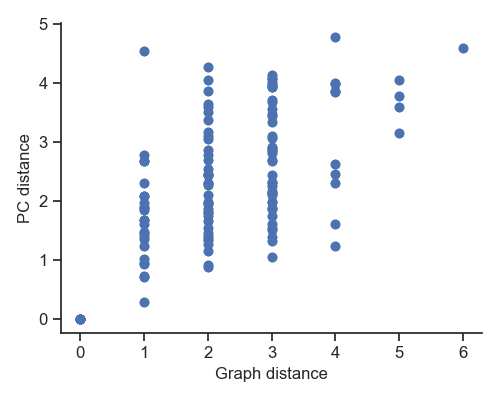

In [133]:
plt.close('all')
fig = plt.figure(figsize=(5,4))
plt.scatter(grid.ravel(),PC_distance.ravel())
plt.xlabel('Graph distance')
plt.ylabel('PC distance')
fig.tight_layout()

<Axes: >

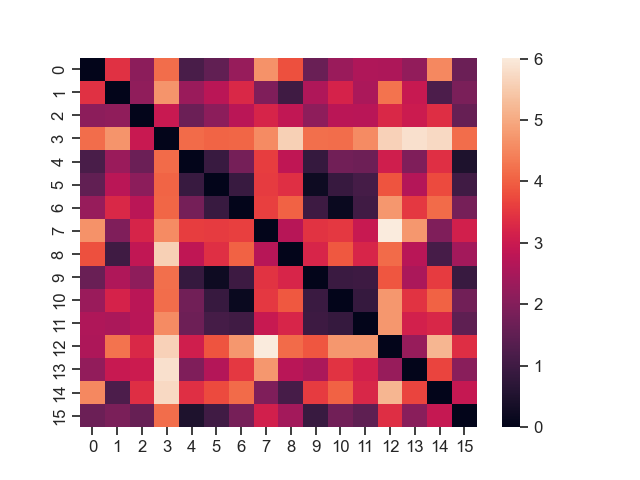

In [101]:
plt.close('all')
sns.heatmap(PC_distance)

In [30]:
nav_target_X = get_mean_FR(choice_df, '(trialerror==0) & ((node==1) | (node==7) | (node==8) | (node==14)) & istarget', 'node')
nav_nottarget_X = get_mean_FR(choice_df, '(trialerror==0) & ((node==1) | (node==7) | (node==8) | (node==14) & ~istarget)', 'node')
flash_X = get_mean_FR(choice_df, 'trialerror==1', 'node')

train_X = np.concatenate([flash_X,nav_target_X,nav_nottarget_X])

pca = PCA(n_components=3)
pca.fit(train_X)

PCA(n_components=3)

In [39]:
targets = [1, 7, 8, 14]
red_X_all = []

for target in targets:
    test_X = get_mean_FR(choice_df, '(trialerror==0) & (target==@target)', 'node')
    red_X = pca.transform(test_X)
    red_X_all.append(red_X)

In [96]:
# target by step 
train_X = []
for step in range(4):
    train_X.append(get_mean_FR(choice_df, 'step==@step & istarget', 'node'))

train_X = np.vstack(train_X)

In [100]:
# target by step 
train_X = []
for step in range(4):
    train_X.append(get_mean_FR(choice_df, 'step==@step & istarget', 'node'))

pca = PCA(n_components=3)
pca.fit(np.vstack(train_X))

red_X_all = []
for step in range(4):
    red_X = pca.transform(train_X[step])
    red_X_all.append(red_X)

In [99]:
# date = '101124'
choice_df['blocktrialnumber']=choice_df.groupby(['Session','block','trial']).cumcount()+1

In [89]:
flash_X1 = get_mean_FR(choice_df, '(trialerror==1) & (blocktrialnumber==1)', 'node')
flash_X2 = get_mean_FR(choice_df, '(trialerror==1) & (blocktrialnumber==2)', 'node')

In [123]:
nav_X1 = get_mean_FR(choice_df, '(trialerror==0) & ((node==1) | (node==7) | (node==8) | (node==14)) & istarget & (blocktrialnumber==3)', 'node')
nav_X2 = get_mean_FR(choice_df, '(trialerror==0) & ((node==1) | (node==7) | (node==8) | (node==14)) & istarget & (blocktrialnumber==4)', 'node')
nav_X3 = get_mean_FR(choice_df, '(trialerror==0) & ((node==1) | (node==7) | (node==8) | (node==14)) & istarget & (blocktrialnumber==5)', 'node')
nav_X4 = get_mean_FR(choice_df, '(trialerror==0) & ((node==1) | (node==7) | (node==8) | (node==14)) & istarget & (blocktrialnumber==6)', 'node')

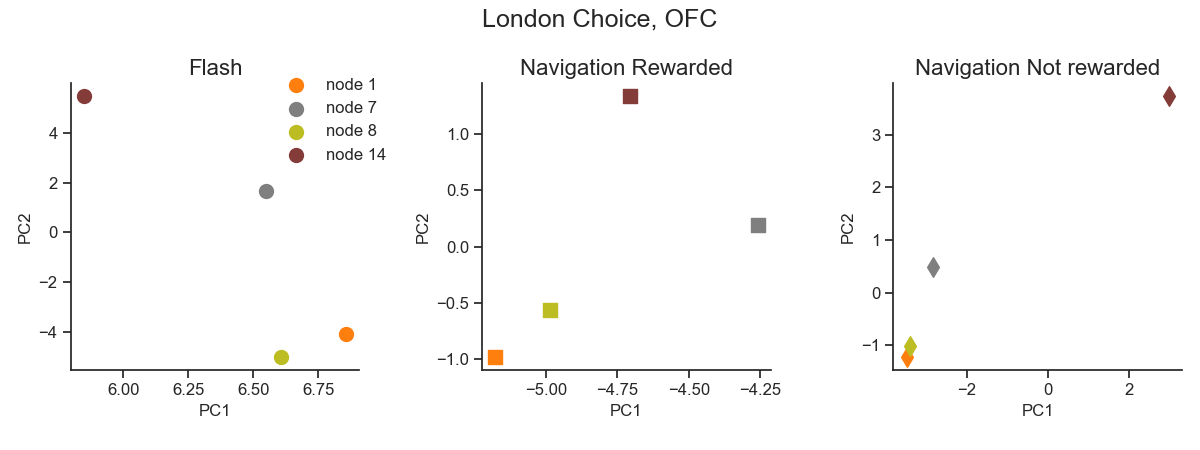

In [148]:
targets = [1, 7, 8, 14]
# red_X_all = [pca.transform(flash_X),pca.transform(nav_target_X),pca.transform(nav_nottarget_X)]
# red_X_all = [pca.transform(flash_X1),pca.transform(flash_X2),pca.transform(nav_X1),pca.transform(nav_X2)]

# for target in targets:
#     test_X = get_mean_FR(choice_df, '(trialerror==0) & (target==@target)', 'istarget')
#     red_X = pca.transform(test_X)
#     red_X_all.append(red_X)

# red_X_all = [pca.transform(nav_X),pca.transform(flash_X)]
markers = ['o','s','d','+']
titles = ['Flash','Navigation Rewarded','Navigation Not rewarded']
# titles = ['Flash 1', 'Flash 2', 'Nav 1', 'Nav 2']
# titles = ['step 0','step 1','step 2','step 3']
# titles = ['Target 1','Target 7','Target 8','Target 14']

fig2, axes = plt.subplots(1, len(red_X_all), figsize=(4*len(red_X_all), 4.5))

for ii in range(len(red_X_all)):
    ax = axes[ii]
    # PC1 vs PC2 (you can change to PC1 vs PC3 if desired)
    for jj, target in enumerate(targets):
        x, y = red_X_all[ii][jj, 0], red_X_all[ii][jj, 1]
        ax.scatter(x, y, color=colors16[target], s=100,marker=markers[ii],label=f"node {target}")
        # ax.text(x-0.4, y+0.1, str(target), fontsize=9, ha="center")
        if ii==0:
            ax.legend(frameon=False,loc=(0.7,0.7))
    
    # ax.set_xlim(-2, 4)
    # ax.set_ylim(-6, 2)
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_title(titles[ii],fontsize=16)

plt.suptitle("Bart Choice, HPC", fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 1])
plt.savefig('Bart HPC target nodes, nav target flash')


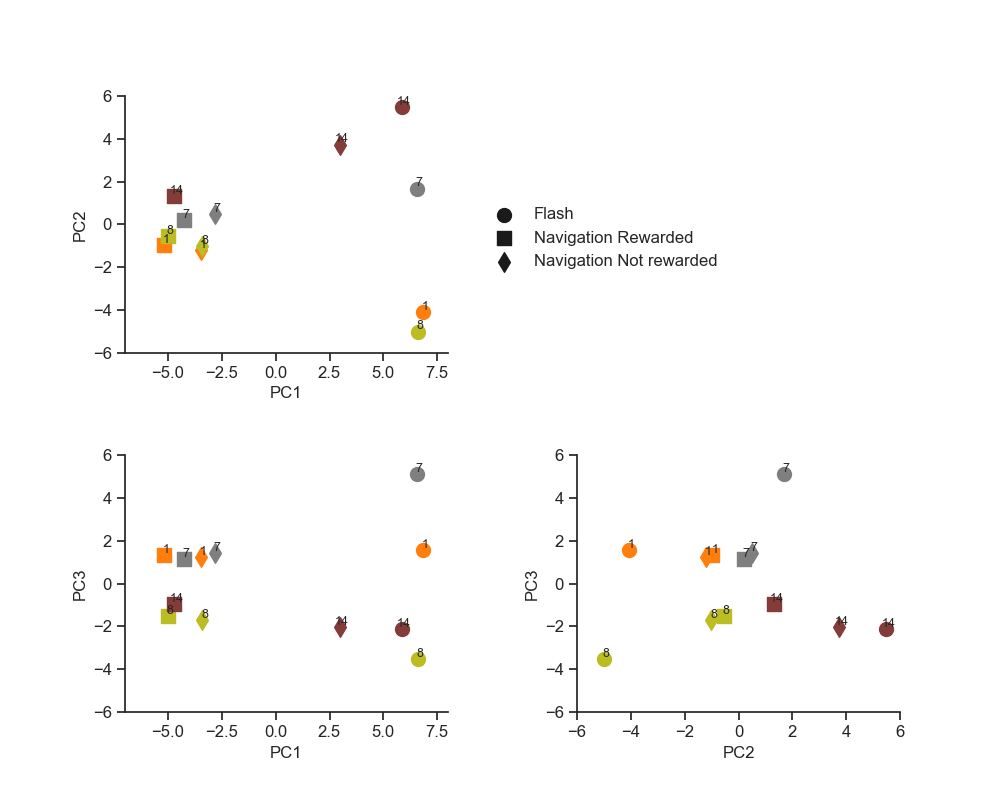

In [156]:
plt.close('all')
fig2, axes = plt.subplots(2, 2, figsize=(10, 8))
markers=['o','s','d','+']

for jj in range(len(red_X_all)):

    reduced_coef = red_X_all[jj]
    
    # PC1 vs PC2
    ax12 = axes[0,0]
    for ii, target in enumerate(targets):
        x, y = reduced_coef[ii, 0], reduced_coef[ii, 1]
        ax12.scatter(x, y, color=colors16[target], s=100,marker=markers[jj])
        ax12.text(x+0.1, y+0.1, str(target), fontsize=9, ha="center")
    ax12.set_xlim(-7,8)
    ax12.set_ylim(-6,6)
    ax12.set_xlabel("PC1")
    ax12.set_ylabel("PC2")
    # ax12.set_title("Projection on PC1-PC2")
    ax12.scatter(-8, 0, color='k', s=100,marker=markers[jj],label=titles[jj])
    ax12.legend(frameon=False, loc=(1.1,0.3))

    # PC1 vs PC3
    ax13 = axes[1,0]
    for ii, target in enumerate(targets):
        x, z = reduced_coef[ii, 0], reduced_coef[ii, 2]
        ax13.scatter(x, z, color=colors16[target], s=100,marker=markers[jj])
        ax13.text(x+0.1, z+0.1, str(target), fontsize=9, ha="center")
    ax13.set_xlabel("PC1")
    ax13.set_ylabel("PC3")
    ax13.set_xlim(-7,8)
    ax13.set_ylim(-6,6)
    # ax13.set_title("Projection on PC1-PC3")
    
    # PC2 vs PC3
    ax23 = axes[1,1]
    for ii, target in enumerate(targets):
        y, z = reduced_coef[ii, 1], reduced_coef[ii, 2]
        ax23.scatter(y, z, color=colors16[target], s=100,marker=markers[jj])
        ax23.text(y+0.1, z+0.1, str(target), fontsize=9, ha="center")
    ax23.set_xlabel("PC2")
    ax23.set_ylabel("PC3")
    ax23.set_xlim(-6,6)
    ax23.set_ylim(-6,6)
    # ax23.set_title("Projection on PC2-PC3")


    axes[0,1].set_visible(False)
    
    plt.subplots_adjust(wspace=0.4,hspace=0.4)
    # plt.suptitle('London Choice, Target=%i' % target)
    plt.savefig('London OFC target, nav target flash')

In [15]:
nav_target_X = get_mean_FR(choice_df, '(trialerror==0) & ((node==1) | (node==7) | (node==8) | (node==14)) & istarget', 'node')
nav_nottarget_X = get_mean_FR(choice_df, '(trialerror==0) & ((node==1) | (node==7) | (node==8) | (node==14) & ~istarget)', 'node')
red_X_all = [pca.transform(nav_target_X),pca.transform(nav_nottarget_X)]

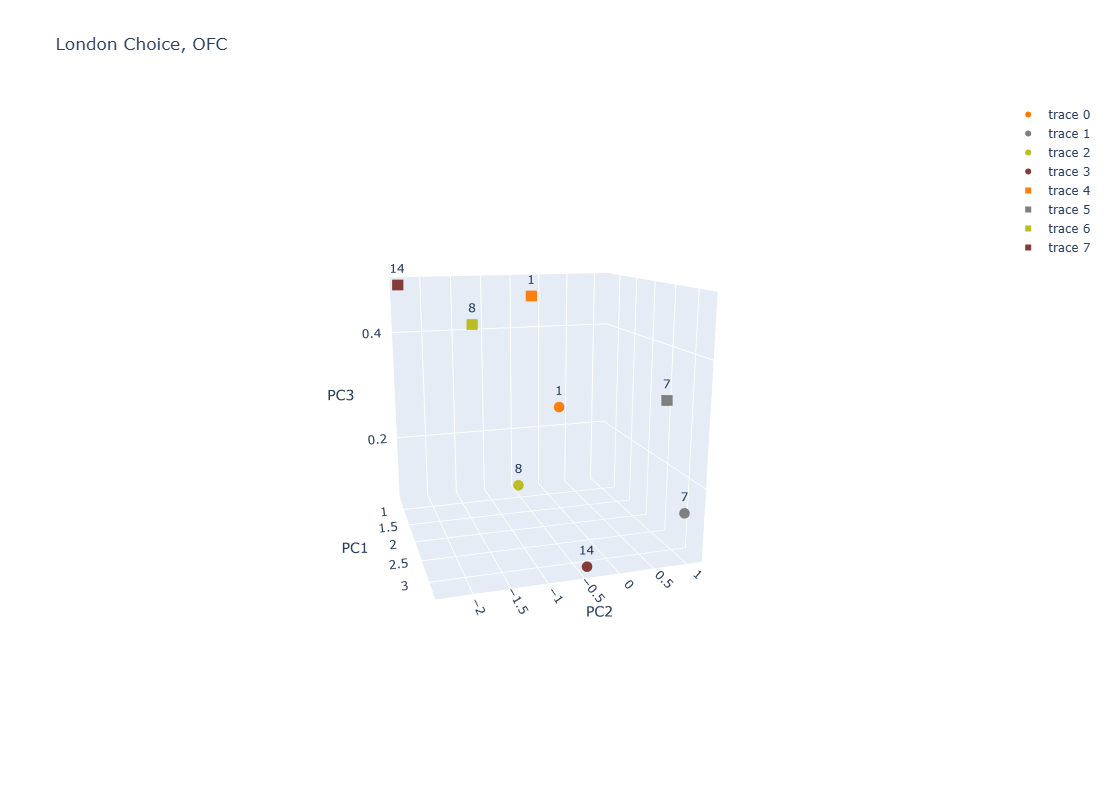

In [19]:
import plotly.graph_objects as go
markers = ['circle','square','diamond','cross']
targets = [1,7,8,14]
fig = go.Figure()

# Loop through jj and targets
for jj in range(len(red_X_all)):
    reduced_coef = red_X_all[jj]

    for ii, target in enumerate(targets):
        x, y, z = reduced_coef[ii, 0], reduced_coef[ii, 1], reduced_coef[ii, 2]

        fig.add_trace(go.Scatter3d(
            x=[x], y=[y], z=[z],
            mode="markers+text",
            marker=dict(size=6, color=colors16[target], symbol=markers[jj]),
            text=[str(target)],
            textposition="top center",
        ))

# Set axes labels and title
fig.update_layout(
    scene=dict(
        xaxis_title="PC1",
        yaxis_title="PC2",
        zaxis_title="PC3"
    ),
    title="London Choice, OFC",
    width=800,
    height=800
)

# Save to interactive HTML
# fig.write_html("London OFC choice nav target flash.html")

fig.show()



In [105]:
T = create_grid(4,teleports=[[0,15]])
grid = distance_matrix(T)

In [43]:
a=np.zeros(4)
for ii, target in enumerate([1,7,8,14]):
    a[ii]=np.linalg.norm(red_X_all[ii][0,:]-red_X_all[ii][15,:])

In [65]:
freq = choice_df.query('step==0').groupby(['target']).use_tele.mean().values

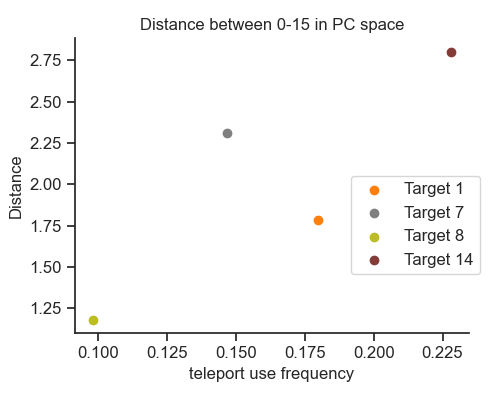

In [87]:
plt.close('all')
fig = plt.figure(figsize=(5,4))
for ii, target in enumerate([1,7,8,14]):
    plt.scatter(freq[ii],a[ii],color=colors16[target],label='Target %i'%target)
plt.legend(loc=(0.7,0.2))
plt.xlabel('teleport use frequency')
plt.ylabel('Distance')
plt.title('Distance between 0-15 in PC space')
fig.tight_layout()

In [281]:
distance_mat = np.zeros((4,4,16,2))

for ii, target in enumerate([1,7,8,14]):
    for jj,ref in enumerate([1,7,8,14]):
        for nn in range(16):
            distance_mat[ii,jj,nn,0] = grid[ref,nn]
            distance_mat[ii,jj,nn,1] = np.linalg.norm(red_X_all[jj][ref,:]-red_X_all[ii][nn,:])

In [283]:
comp = np.zeros((4,2,16))
for ii in range(4):
    comp[ii,0,:] = distance_mat[ii,ii,:,1]
    comp[ii,1,:] = distance_mat[ii,np.arange(4)!=ii,:,1].mean(axis=0)

comp[comp==0]=np.nan

In [295]:
stats.ttest_rel(comp[3,0,:].ravel(),comp[3,1,:].ravel(),nan_policy="omit")

TtestResult(statistic=17.76943983198556, pvalue=5.307948068032356e-11, df=14)

In [303]:
choice_df.groupby(['target','istarget']).count()

Session  start_time  stop_time  trial  step  trialerror  \
target istarget                                                            
1.0    False        2861        2861       2861   2861  2861        2861   
       True         1590        1590       1590   1590  1590        1590   
7.0    False        3238        3238       3238   3238  3238        3238   
       True         1603        1603       1603   1603  1603        1603   
8.0    False        3116        3116       3116   3116  3116        3116   
       True         1581        1581       1581   1581  1581        1581   
14.0   False        2820        2820       2820   2820  2820        2820   
       True         1570        1570       1570   1570  1570        1570   

                 nsteps  start  block  blocktrialnumber  ...  t_on  \
target istarget                                          ...         
1.0    False       2861   2861   2861              2861  ...  2861   
       True        1590   1590   1590              1590  ...  1590   
7.0    False       3238   3238   3238              3238  ...  3238   
       True        1603   1603   1603              1603  ...  1603   
8.0    False       3116   3116   3116              3116  ...  3116   
       True        1581   1581   1581              1581  ...  1581   
14.0   False       2820   2820   2820              2820  ...  2820   
       True        1570   1570   1570              1570  ...  1570   

                 graph_distance  spatial_distance  window_size  nodes    FR  \
target istarget                                                               
1.0    False               2861              2861         2861   2861  2861   
       True                1590              1590         1590   1590  1590   
7.0    False               3238              3238         3238   3238  3238   
       True                1603              1603         1603   1603  1603   
8.0    False               3116              3116         3116   3116  3116   
       True                1581              1581         1581   1581  1581   
14.0   False               2820              2820         2820   2820  2820   
       True                1570              1570         1570   1570  1570   

                 normFR  use_tele  prenode  postnode  
target istarget                                       
1.0    False       2861      2861     2861      2861  
       True        1590      1590     1590      1590  
7.0    False       3238      3238     3238      3238  
       True        1603      1603     1603      1603  
8.0    False       3116      3116     3116      3116  
       True        1581      1581     1581      1581  
14.0   False       2820      2820     2820      2820  
       True        1570      1570     1570      1570  

[8 rows x 22 columns]

Text(0.5, 1.05, 'Distance to target in the PC space')

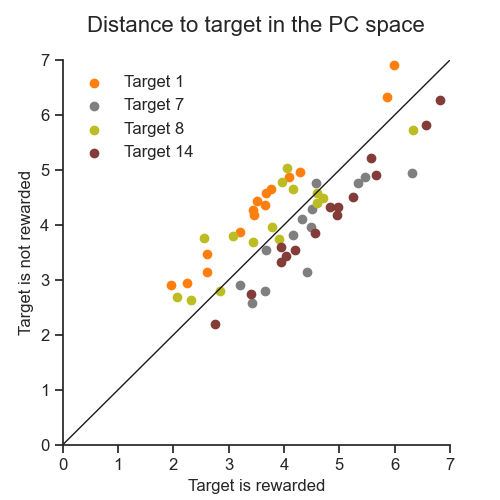

In [287]:
plt.close('all')
plt.figure(figsize=(5,5))
for ii, target in enumerate(targets):
    plt.scatter(comp[ii,0,:],comp[ii,1,:],color=colors16[target],label='Target %i' % target)
plt.plot([0,7],[0,7],'k-')
plt.xlim(0,7)
plt.ylim(0,7)
plt.legend(frameon=False)
plt.xlabel('Target is rewarded')
plt.ylabel('Target is not rewarded')
plt.title('Distance to target in the PC space',fontsize=16,y=1.05)

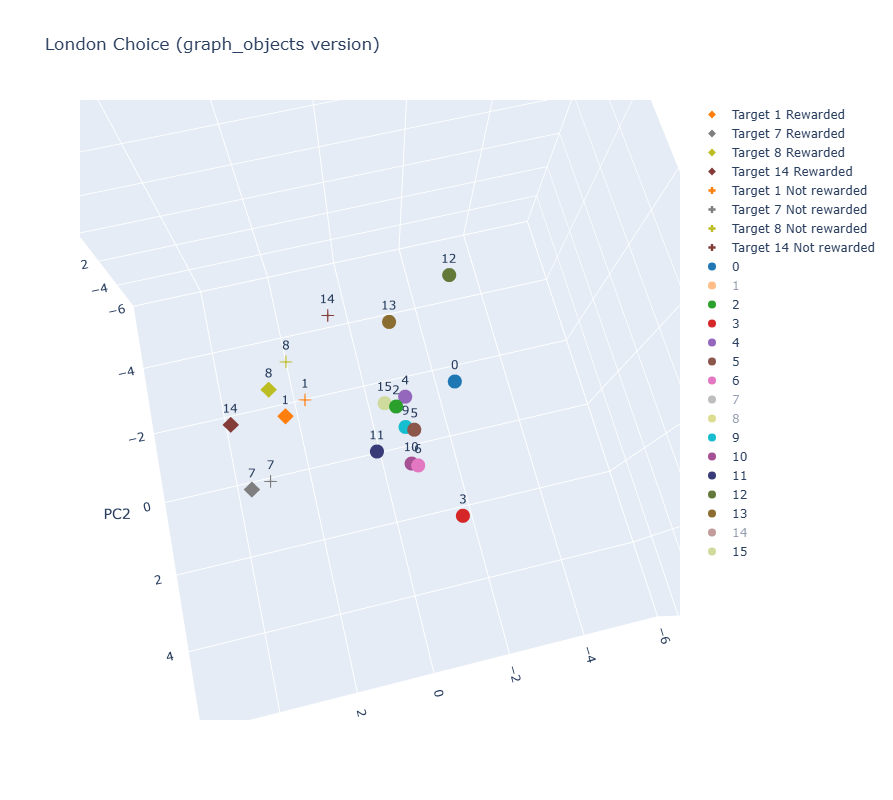

In [35]:
import plotly.graph_objects as go

fig = go.Figure()
# red_X = pca.transform(train_X)
# reduced_coef: shape (n_points, 3)
# targets: class labels (same length as reduced_coef)
# colors16: list/dict of colors indexed by target
# markers: list of marker symbols (e.g. ["circle", "square", "diamond"])

titles = ['Target 1','Target 7','Target 8','Target 14']
markers = ["circle", "square", "diamond","cross"]
targets=[1,7,8,14]
condition=['Rewarded','Not rewarded']


# Loop through jj and targets
for jj in range(len(red_X_all)):
    
    reduced_coef = red_X_all[jj]

    for ii, target in enumerate(targets):
        x, y, z = reduced_coef[ii, 0], reduced_coef[ii, 1], reduced_coef[ii, 2]

        fig.add_trace(go.Scatter3d(
            x=[x], y=[y], z=[z],
            mode="markers+text",
            marker=dict(size=6, color=colors16[target], symbol=markers[jj+2]),
            text=[str(target)],
            textposition="top center",
            name=titles[ii]+' '+condition[jj]
        ))

red_X = pca.transform(train_X)
for ii in range(16):
    # ii=3
    x, y, z = red_X[ii, 0], red_X[ii, 1], red_X[ii, 2]

    fig.add_trace(go.Scatter3d(
        x=[x], y=[y], z=[z],
        mode="markers+text",
        marker=dict(
            size=8,
            color=colors16[ii],   # choose color based on target
            symbol=markers[0]
                # or markers[ii] depending on setup
        ),
        text=[str(ii)],          # show target label
        textposition="top center",
        name=str(ii)             # legend entry
    ))

# Axis titles
fig.update_layout(
    scene=dict(
        xaxis=dict(title="PC1", range=[-6, 6]),
        yaxis=dict(title="PC2", range=[-6, 6]),
        zaxis=dict(title="PC3", range=[-6, 6]),
    ),
    title="London Choice (graph_objects version)",
    width=800,
    height=800
)

# Save as interactive HTML
# fig.write_html("Bart node first step.html")

fig.show()


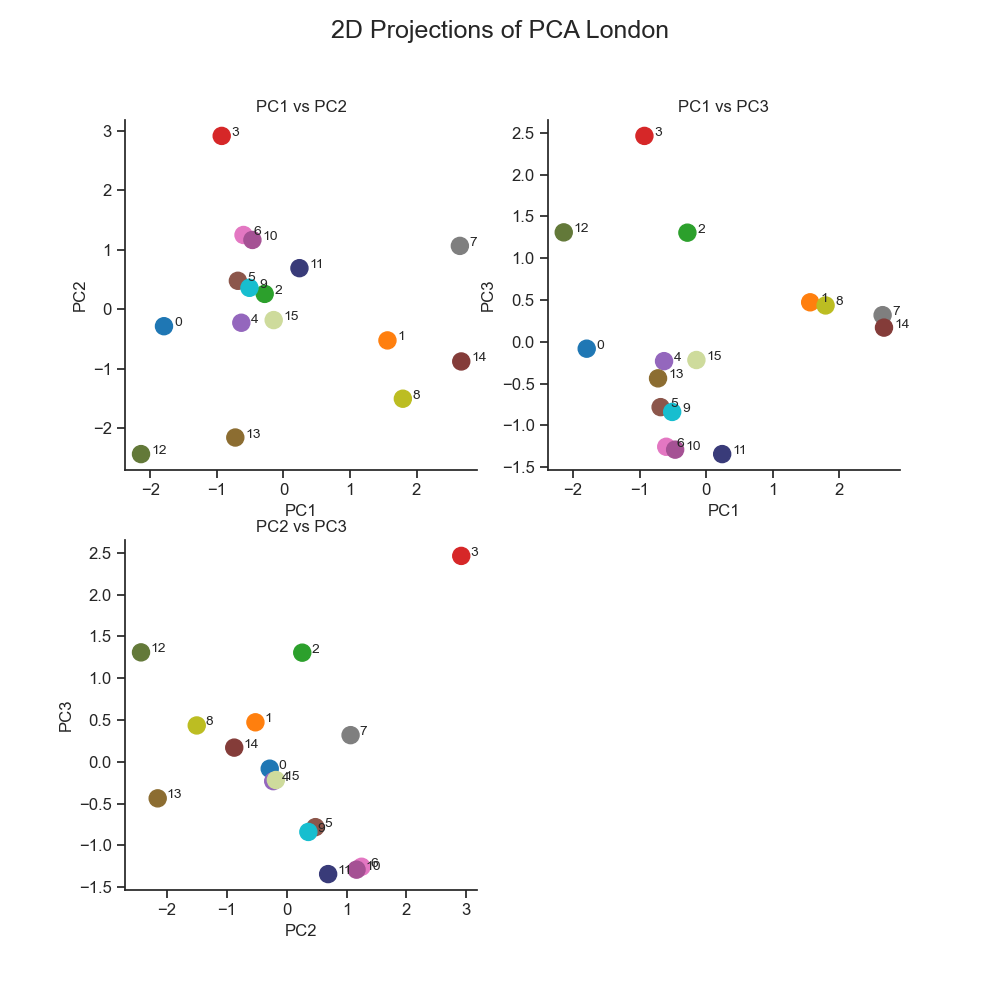

In [77]:
plt.close('all')

# ---- 2D projections ----
fig2d, axes = plt.subplots(2,2,figsize=(10,10))

# PC1 vs PC2
axes[0,0].scatter(red_X[:,0], red_X[:,1], c=colors16, s=150)
for ii in range(16):
    axes[0,0].text(red_X[ii,0]+0.15, red_X[ii,1], str(ii), fontsize=10)
axes[0,0].set_xlabel("PC1")
axes[0,0].set_ylabel("PC2")
axes[0,0].set_title("PC1 vs PC2")

# PC1 vs PC3
axes[0,1].scatter(red_X[:,0], red_X[:,2], c=colors16, s=150)
for ii in range(16):
    axes[0,1].text(red_X[ii,0]+0.15, red_X[ii,2], str(ii), fontsize=10)
axes[0,1].set_xlabel("PC1")
axes[0,1].set_ylabel("PC3")
axes[0,1].set_title("PC1 vs PC3")

# PC2 vs PC3
axes[1,0].scatter(red_X[:,1], red_X[:,2], c=colors16, s=150)
for ii in range(16):
    axes[1,0].text(red_X[ii,1]+0.15, red_X[ii,2], str(ii), fontsize=10)
axes[1,0].set_xlabel("PC2")
axes[1,0].set_ylabel("PC3")
axes[1,0].set_title("PC2 vs PC3")

# Empty subplot (bottom right)
axes[1,1].axis("off")

fig2d.suptitle("2D Projections of PCA London", fontsize=18)
plt.savefig("2D Projections of PCA London")

# plt.tight_layout()


(-0.15000000000000002, 3.15, -3.15, 0.15000000000000002)

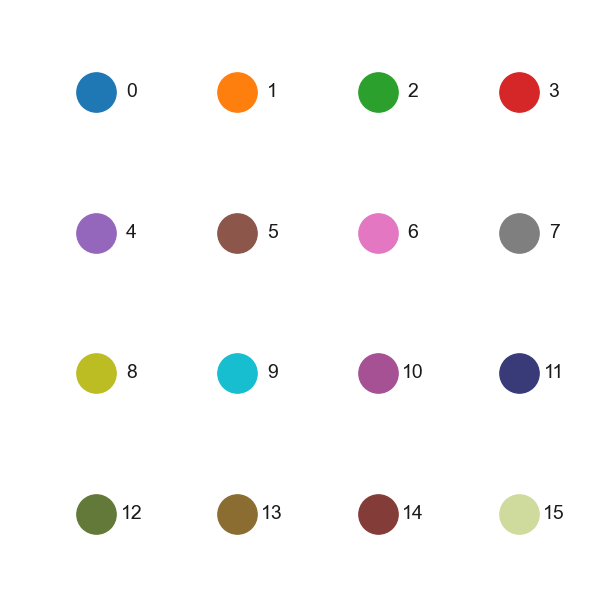

In [29]:
# Right 2D grid
plt.close('all')
plt.figure(figsize=(6,6))
for ii in range(16):
    row, col = divmod(ii, 4)
    plt.scatter(col, -row, color=colors16[ii], s=800, edgecolor=None)
    plt.text(col+0.25, -row, str(ii), ha="center", va="center",
              color="k", fontsize=14)

# plt.xlim(-2, 5)
# plt.ylim(-5, 2)
# plt.xticks(range(4))
# plt.yticks([-0, -1, -2, -3], [0, 1, 2, 3])
# plt.title("Color grid")
plt.axis('equal')
plt.axis('off')


In [37]:
def create_grid(n,barriers=[],teleports=[]):

    # create n*n grid, transition matrix
    T = np.zeros((n*n,n*n))
    block = np.diag(np.ones(n-1), k=1) + np.diag(np.ones(n-1), k=-1)
    
    for c in range(n):
        T[c*n:(c+1)*n,c*n:(c+1)*n] = block
        cols = np.arange(c, n*n, n)  
        row_idx, col_idx = np.meshgrid(cols, cols, indexing='ij')  # shape (4, 4)
        T[row_idx, col_idx] = block

    if len(barriers)>0:
        for barrier in barriers:
            T[barrier[0],barrier[1]]=0
            T[barrier[1],barrier[0]]=0

    if len(teleports)>0:
        for teleport in teleports:
            T[teleport[0],teleport[1]]=1
            T[teleport[1],teleport[0]]=1  
    
    return T


def distance_matrix(T):
    
    # calculate distance 
    n_state = T.shape[0]
    D=np.zeros((n_state,n_state))
    step=0
    connected = np.eye(n_state)
    nsteps = np.eye(n_state)

    if np.sum(T.mean(axis=0)==0)>0:

        D = np.nan    # check if all the nodes are reachable

    else:
    
        while connected.mean()<1:
        
            step=step+1
            nsteps = np.dot(nsteps,T)*(1-connected)
        
            D[nsteps>0]=step
            connected[nsteps>0]=1

    return D